---
title: "[Law Graph Visualization](https://colab.research.google.com/drive/1bS6ZMkCtmqrbWvSQLC-Y6crRXwrKyYKI?usp=sharing)"
---




This notebook presents an interactive visualization of the **legal knowledge graph**.  
The graph makes explicit the structural relationships between statutory provisions that are otherwise difficult to observe through text-only retrieval.

This visualization serves both as a **diagnostic tool** and as an **explanatory aid** for understanding how graph enhancement influences retrieval and downstream answer generation.

## Build and Load the Graph

After pull the project source code, the preprocessing stage constructs a legal knowledge graph to capture structural relationships:
```python
git clone https://github.com/Fan-Luo/Legal-RAG.git
pip install -e .
python -m scripts.preprocess_law
python -m scripts.build_graph
```

In [1]:
#| include: false

!git clone https://github.com/Fan-Luo/Legal-RAG.git
%cd Legal-RAG

# For demo purpose, load preprocessed law data
!python -m scripts.setup

Cloning into 'Legal-RAG'...
remote: Enumerating objects: 751, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 751 (delta 186), reused 234 (delta 168), pack-reused 454 (from 1)
Receiving objects: 100% (751/751), 963.31 KiB | 12.51 MiB/s, done.
Resolving deltas: 100% (378/378), done.
/content/Legal-RAG


In [2]:
#| include: false

import json, os
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict, deque
from legalrag.schemas import LawNode, Neighbor
from typing import Any, Dict, Iterable, List, Optional, Tuple
from pathlib import Path
import pandas as pd
import matplotlib as mpl
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

mpl.rcParams["font.sans-serif"] = ["Noto Sans CJK SC", "SimHei", "Arial Unicode MS"]
mpl.rcParams["axes.unicode_minus"] = False
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

## What This Graph Represents

**Nodes** correspond to individual legal provisions (e.g., articles or clauses).

**Edges** encode structural relationships, capturing  referential and contextual dependencies among laws.

The graph is constructed offline from preprocessed legal texts and stored as a static HTML artifact for reproducible inspection.

In [3]:
#| code-fold: false

from legalrag.config import AppConfig
from legalrag.retrieval.graph_store import LawGraphStore

cfg = AppConfig.load(None)
store = LawGraphStore(cfg)

In [4]:
#| include: false

from scripts.quiet import install_quiet
install_quiet(message_only_loggers=["legalrag.retrieval.graph_store"])

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


In [5]:
#| echo: false

store.load()

[Graph] Loaded 1260 law nodes
[Graph] Built adjacency: 2640 edges


In [6]:
#| echo: false
#| code-fold: false

node = store.nodes["142"]

print("Example graph node:")
print(f"  Article ID   : {node.article_id}")
print(f"  Article No   : {node.article_no}")
print(f"  Law          : {node.law_name}")
print(f"  Chapter      : {node.chapter}")
print(f"  Section      : {node.section}")
print()
print("  Neighbors:")
for nb in node.neighbors:
    print(
        f"    - {nb.article_id:>4} | "
        f"rel={nb.relation:<6} | "
        f"conf={nb.conf:.2f} | "
        f"evidence={nb.evidence}"
    )


Example graph node:
  Article ID   : 142
  Article No   : 第一百四十二条
  Law          : 中华人民共和国民法典
  Chapter      : 六章 民事法律行为
  Section      : 三节 民事法律行为的效力

  Neighbors:
    -  141 | rel=prev   | conf=1.00 | evidence=None
    -  143 | rel=next   | conf=1.00 | evidence=None
    -  466 | rel=cited  | conf=0.90 | evidence={'span': [30, 37], 'text': '第一百四十二条'}


In [7]:
#| include: false

neighbors = store.nodes['142'].neighbors
neighbors

[Neighbor(article_id='141', relation='prev', conf=1.0, evidence=None),
 Neighbor(article_id='143', relation='next', conf=1.0, evidence=None),
 Neighbor(article_id='466', relation='cited', conf=0.9, evidence={'span': [30, 37], 'text': '第一百四十二条'})]

## Graph Walk Retrieval

Graph-based expansion performs a bounded breadth-first search (BFS) over the legal knowledge graph, starting from one or more seed articles. The goal is to retrieve a localized subgraph centered on the query nodes, while allowing fine-grained control over relation types, confidence thresholds, and the total number of returned nodes. The resulting nodes are used to induce a subgraph for visualization or downstream analysis.

In [8]:
#| echo: false
#| code-fold: false

G = nx.DiGraph()

# Add nodes
for node in store.adj.keys():
    G.add_node(node)

# Add edges with relation labels
for src, node in store.nodes.items():
    for e in node.neighbors:
        G.add_edge(src, e.article_id, relation=e.relation)

In [9]:
#| code-summary: Perform a graph walk from seed legal articles to retrieve a localized subgraph
#| code-fold: false

start_ids = ["582"]
law_nodes = store.walk(start_ids, limit = 30)
node_ids = [node.article_id for node in law_nodes] + start_ids

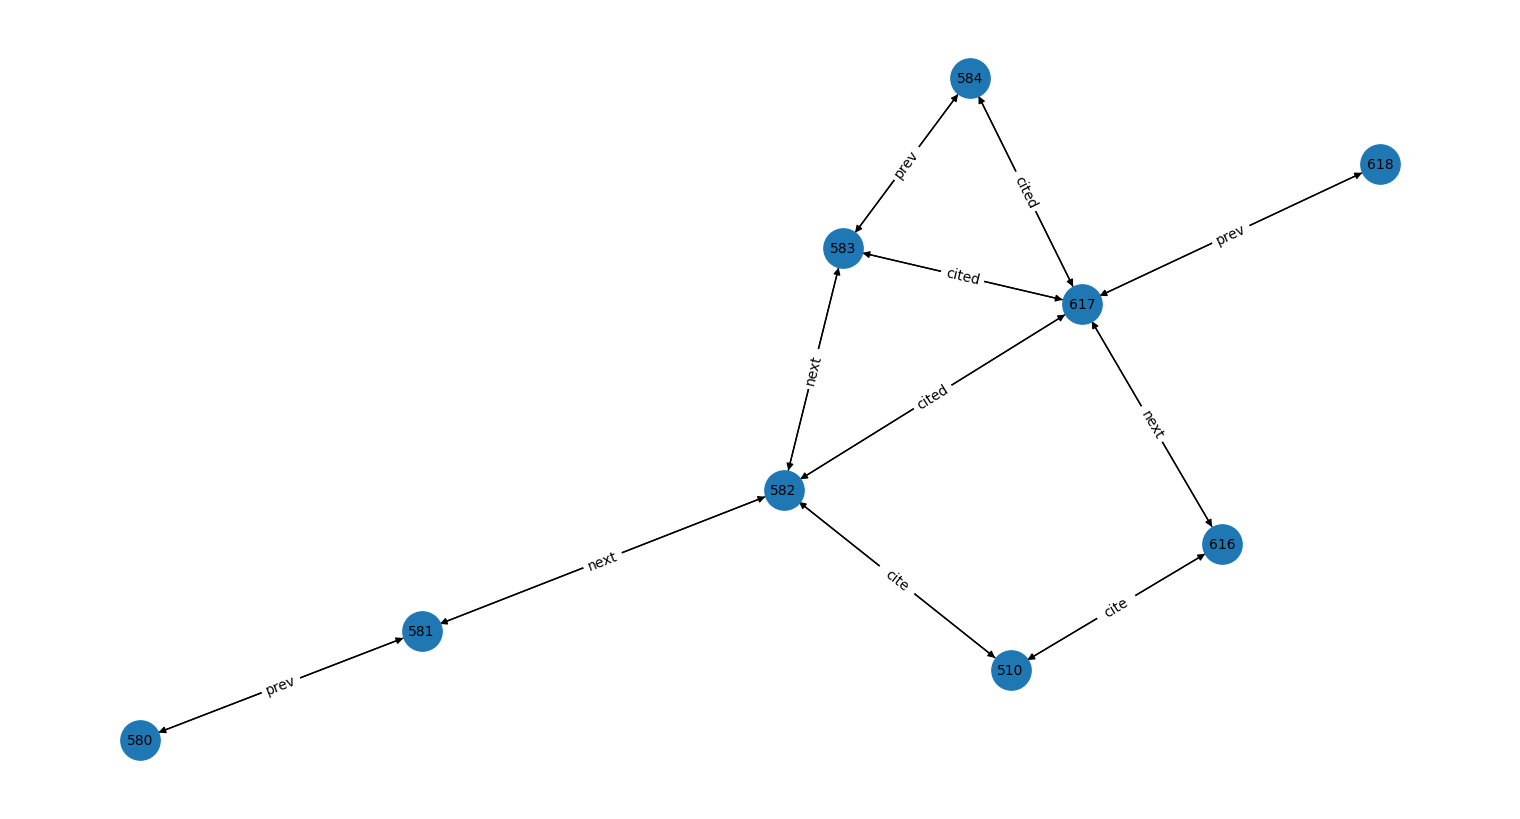

In [10]:
#| echo: false

sub = G.subgraph(node_ids)
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(sub, seed=42)
nx.draw(sub, pos, with_labels=True, node_size=800, font_size=10)
nx.draw_networkx_edge_labels(sub, pos, edge_labels=nx.get_edge_attributes(sub, "relation"))
plt.show()

## Visualizing the Legal Knowledge Graph

This section visualizes the full legal knowledge graph as an interactive network to facilitate inspection and analysis of structural relationships between legal articles. Nodes represent individual law articles, while directed edges encode relational links such as sequential ordering, citations, or doctrinal dependencies.

This visualization complements quantitative retrieval metrics by providing a **qualitative view** of legal structure and coverage.


In [11]:
#| echo: false
#| code-fold: false

from pyvis.network import Network
import os

# Create network (notebook=True for inline display in Jupyter/Quarto)
net = Network(
    notebook=True,
    height="900px",
    width="100%",
    bgcolor="#ffffff",
    font_color="black",
    cdn_resources="in_line"
)

# Add nodes with Chinese-friendly styling
for n in G.nodes():
    net.add_node(
        n,
        label=str(n),
        title=f"Article {n}",
        shape="circle",
        size=25,
        color={
            "background": "#97c2fc",
            "border": "#2b7ce9"
        },
        font={
            "color": "#000000",
            "size": 14,
            "face": "Microsoft YaHei, Helvetica, Arial, sans-serif",
            "align": "middle",
            "multi": True,
            "bold": True
        }
    )

# Add edges
for u, v, data in G.edges(data=True):
    net.add_edge(
        u, v,
        label=data.get("relation", ""),
        font={"size": 11, "align": "middle"}
    )

# Save to file (optional, for external use)
GRAPH_PATH = "data/graph/law_graph.html"
net.write_html(GRAPH_PATH)



<iframe
  src="../data/graph/law_graph.html"
  width="100%"
  height="900"
  style="border: none;"
  loading="lazy">
</iframe>


In [12]:
#| include: false

# from IPython.display import HTML, display

# with open(GRAPH_PATH, "r", encoding="utf-8") as f:
#     display(HTML(f.read()))